In [56]:
import numpy as np
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BartForConditionalGeneration, BartConfig
from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration, T5Config
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# visualization
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/NanumFont/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Tokenizer 정의

In [2]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
model_dir = "lcw99/t5-base-korean-text-summary"
tokenizer = T5TokenizerFast.from_pretrained(model_dir) 

# https://huggingface.co/paust/pko-t5-base
# transformers 의 API 를 사용하여 접근 가능합니다. 
# tokenizer 를 사용할때는 T5Tokenizer 가 아니라 T5TokenizerFast 를 사용해주십시오. 
# model 은 T5ForConditionalGeneration 를 그대로 활용하시면 됩니다.

In [3]:
print(tokenizer.eos_token)
print(tokenizer.unk_token)
print(tokenizer.pad_token)

</s>
<pad>
<pad>


# Config 정의

In [4]:
config_data = {
    "general": {
        "data_path": "your_path", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": f"{model_dir}", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": "./" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 1024,
        "decoder_max_len": 150,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        "unk_token": f"{tokenizer.unk_token}",
        "pad_token": f"{tokenizer.pad_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#Person4#', '#Person5#', '#Person6#', '#Person7#',
                           '#DateOfBirth#', '#CarNumber#', '#Email#', '#CardNumber#', '#Address#', '#SSN#', '#PhoneNumber#', '#PassportNumber#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 50,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 4, # 50
        "per_device_eval_batch_size": 16, # 32
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 16, # 몇 개의 작은 배치를 합쳐서 큰 배치처럼 처리할지를 결정하는 파라미터: 메모리 제한 극복, 더 나은 성능
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 7,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 150,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 5, # 3
        "early_stopping_threshold": 0.0001, # 0.001
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": "entity_name",
        "project": "project_name",
        "name": "name"
    },
    "inference": {
        "ckt_path": "model ckt path", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "generate_max_length": 150,
        "num_beams": 4,
        "batch_size" : 16, # 32
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.unk_token}", f"{tokenizer.pad_token}"]
    }
}

In [5]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = "./config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

In [6]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

In [7]:
# 이곳에 사용자가 저장한 데이터 dir 설정하기
loaded_config['general']['data_path'] = "../../data"

실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.

Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [9]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train_regular-expression.csv'))
display(train_df.tail())

# dev data의 구조와 내용을 확인합니다.
dev_df = pd.read_csv(os.path.join(data_path,'dev_regular-expression.csv'))
display(dev_df.tail())

# test data의 구조와 내용을 확인합니다.
test_df = pd.read_csv(os.path.join(data_path,'test.csv'))
display(test_df.tail())

# train, dev, test 길이 확인
print(train_df.shape[0], dev_df.shape[0], test_df.shape[0])

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...,탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....,누군가를 태우다
12453,train_12456,#Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...,#Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...,컨퍼런스 센터
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.,차 렌트
12455,train_12458,#Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...,#Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...,실직
12456,train_12459,"#Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...",#Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...,짐 싸기


,fname,dialogue,summary,topic
494,dev_495,#Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...,#Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...,새해
495,dev_496,"#Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...",#Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Person2#...,사랑에 빠지다
496,dev_497,"#Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...",#Person2#의 차에서 이상한 소리가 납니다. #Person1#는 브레이크를 교...,소음
497,dev_498,"#Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...",#Person2#님이 아마존 고객 서비스에 전화하여 아마존에서 받은 책에 한 페이지...,빠진 페이지
498,dev_499,#Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...,#Person2#는 #Person1#에게 여름 휴가 동안 파티를 도와주는 회사에서 ...,여름 휴가


,fname,dialogue
494,test_495,"#Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할..."
495,test_496,#Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...
496,test_497,"#Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻..."
497,test_498,#Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...
498,test_499,"#Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ..."


12457 499 499


# 토큰 개수 확인

## Train

In [28]:
# 토큰화
special_tokens = loaded_config['tokenizer']['special_tokens']

special_tokens_dict={'additional_special_tokens':special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

dialogue_tokenizer = train_df['dialogue'].apply(lambda x: tokenizer(x))
summary_tokenizer = train_df['summary'].apply(lambda x: tokenizer(x))
topic_tokenizer = train_df['topic'].apply(lambda x: tokenizer(x))

dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
summary_len = summary_tokenizer.apply(lambda x: len(x['input_ids']))
topic_len = topic_tokenizer.apply(lambda x: len(x['input_ids']))

temp = dialogue_len.describe().reset_index()
temp0 = summary_len.describe().reset_index()
temp1 = topic_len.describe().reset_index()

temp.merge(temp0, on='index').merge(temp1, on='index')

,index,dialogue,summary,topic
0,count,12457.000000,12457.000000,12457.000000
1,mean,259.183913,48.042386,3.966766
2,std,137.861326,21.893168,1.749306
3,min,59.000000,11.000000,2.000000
4,25%,170.000000,33.000000,3.000000
5,50%,230.000000,44.000000,4.000000
6,75%,321.000000,59.000000,5.000000
7,max,1658.000000,279.000000,74.000000


In [33]:
dialogue_len.shape[0]

12457

In [31]:
dialogue_len[dialogue_len <= 1000]

0        329
1        282
2        181
3        211
4        192
        ... 
12452    448
12453    192
12454    189
12455    282
12456    204
Name: dialogue, Length: 12420, dtype: int64

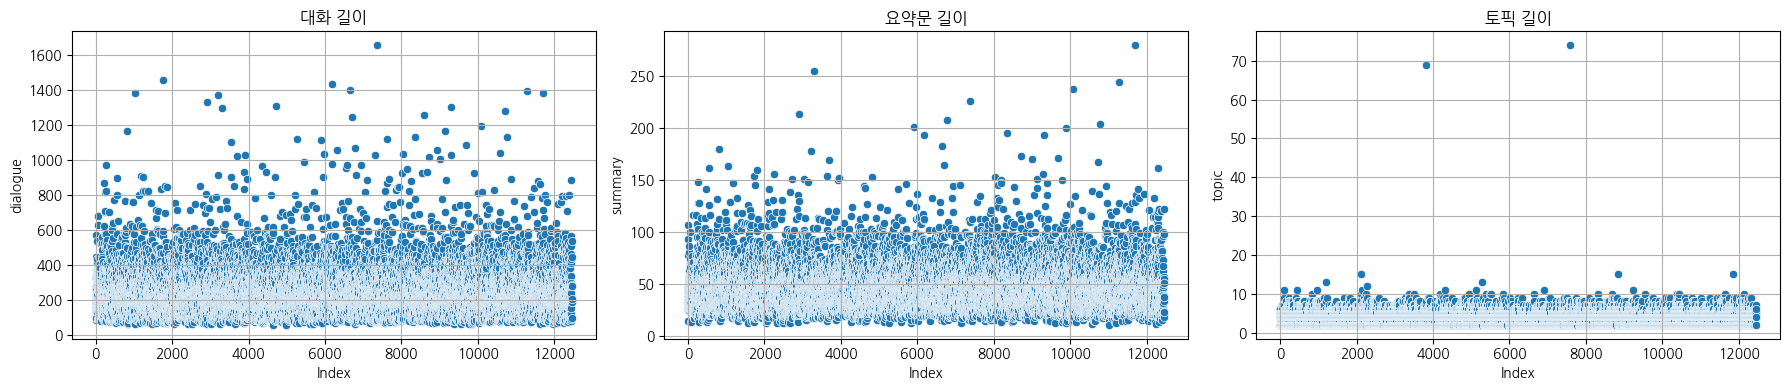

In [11]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_len.reset_index(), x=summary_len.index, y='summary')
plt.title('요약문 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_len.reset_index(), x=topic_len.index, y='topic')
plt.title('토픽 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

## Valid

In [13]:
# 토큰화
special_tokens = loaded_config['tokenizer']['special_tokens']

special_tokens_dict={'additional_special_tokens':special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

dialogue_tokenizer = dev_df['dialogue'].apply(lambda x: tokenizer(x))
summary_tokenizer = dev_df['summary'].apply(lambda x: tokenizer(x))
topic_tokenizer = dev_df['topic'].apply(lambda x: tokenizer(x))

dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
summary_len = summary_tokenizer.apply(lambda x: len(x['input_ids']))
topic_len = topic_tokenizer.apply(lambda x: len(x['input_ids']))

temp = dialogue_len.describe().reset_index()
temp0 = summary_len.describe().reset_index()
temp1 = topic_len.describe().reset_index()

temp.merge(temp0, on='index').merge(temp1, on='index')

,index,dialogue,summary,topic
0,count,499.000000,499.000000,499.000000
1,mean,256.324649,44.116232,4.094188
2,std,130.596065,20.404900,1.497369
3,min,73.000000,13.000000,2.000000
4,25%,171.500000,29.000000,3.000000
5,50%,227.000000,40.000000,4.000000
6,75%,314.000000,53.500000,5.000000
7,max,954.000000,145.000000,12.000000


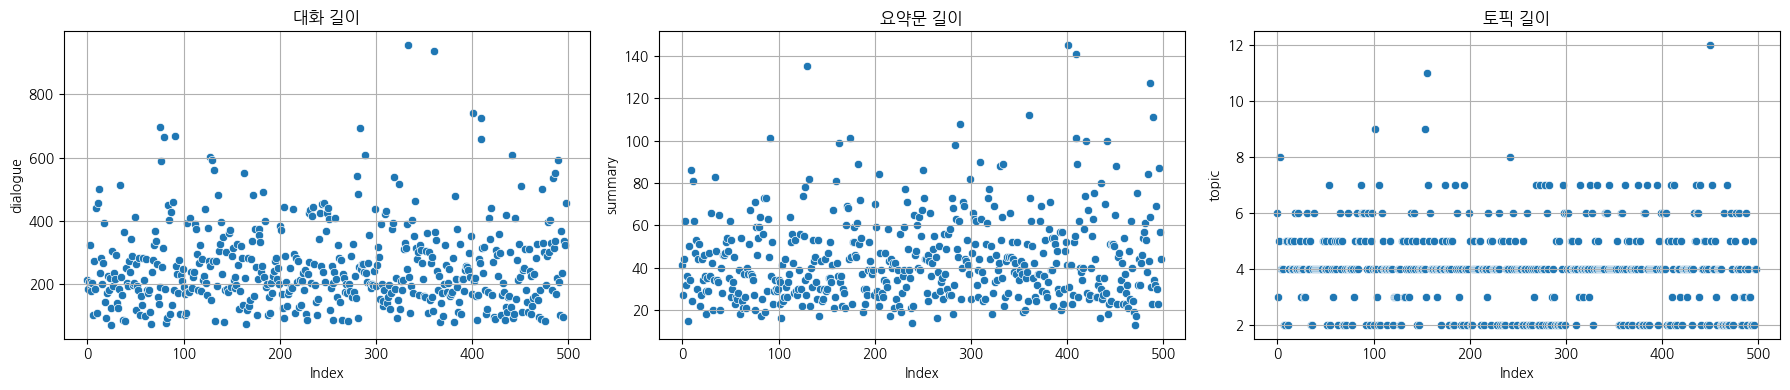

In [14]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_len.reset_index(), x=summary_len.index, y='summary')
plt.title('요약문 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_len.reset_index(), x=topic_len.index, y='topic')
plt.title('토픽 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

## Test

In [25]:
# 토큰화
special_tokens = loaded_config['tokenizer']['special_tokens']

special_tokens_dict={'additional_special_tokens':special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

dialogue_tokenizer = test_df['dialogue'].apply(lambda x: tokenizer(x))
dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
temp = dialogue_len.describe().reset_index()
temp

,index,dialogue
0,count,499.000000
1,mean,266.300601
2,std,149.152996
3,min,66.000000
4,25%,164.000000
5,50%,236.000000
6,75%,333.500000
7,max,1634.000000


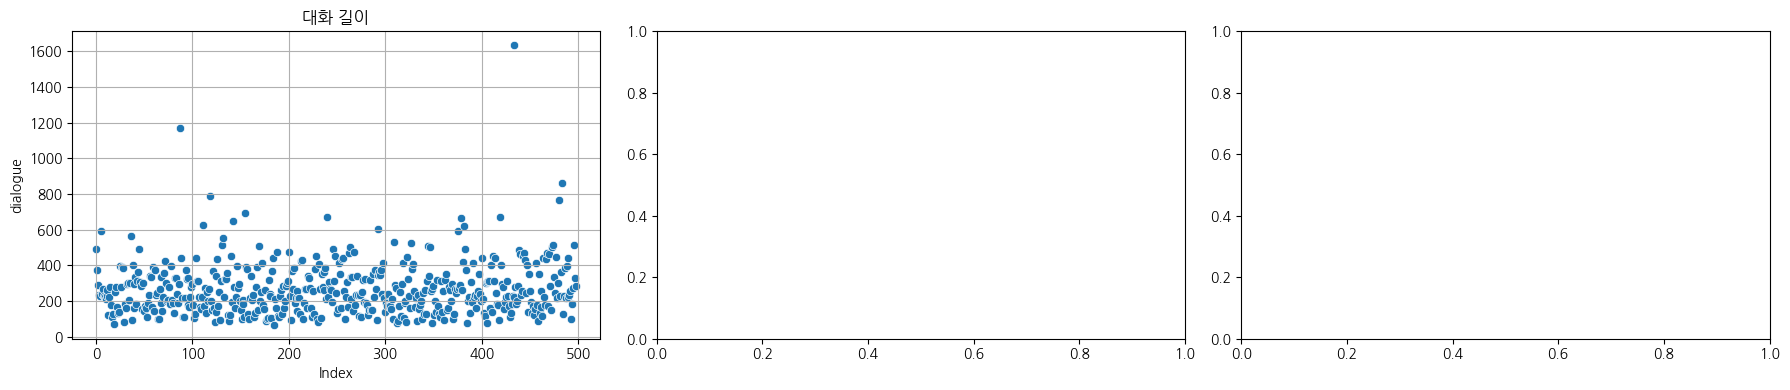

In [26]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot()

plt.subplot(1, 3, 3)
sns.scatterplot()

plt.tight_layout()
plt.show()

In [22]:
dialogue_len[dialogue_len > 1000]

87     1169
434    1634
Name: dialogue, dtype: int64

In [24]:
test_df.iloc[[87, 434], 1]

,fname,dialogue
87,test_87,"#Person1#: 아, 좋은 아침이네요, 로스 씨, 들어오세요.\n#Person2..."
434,test_434,"#Person1#: 헤이, 앤드류! 앤...? 앤드류.\n#Person2#: 뭐?\..."


# 대화문에서 개행문자 기준으로 토큰 길이 확인

## Train

In [39]:
train_n_split = []
for idx in tqdm(range(0, train_df.shape[0])):
    text = train_df.iloc[idx, 1]
    text2 = text.split('\n')
    train_n_split.append(text2)

100%|██████████| 12457/12457 [00:00<00:00, 50796.03it/s]


In [46]:
train_n_token = []
for idx in tqdm(range(0, train_df.shape[0])):
    temp = []
    for text in train_n_split[idx]:
        token = tokenizer(text)
        inp_ids = len(token['input_ids'])
        temp.append(inp_ids)
    train_n_token.append(temp)

100%|██████████| 12457/12457 [00:07<00:00, 1727.81it/s]


In [76]:
# mean, max, min

train_n_token_series = pd.Series(train_n_token, name='dialogue')

train_n_token_mean = train_n_token_series.apply(lambda x: np.mean(x))
train_n_token_max = train_n_token_series.apply(lambda x: np.max(x))
train_n_token_min = train_n_token_series.apply(lambda x: np.min(x))

train_n_token_mean.name = 'mean'
train_n_token_max.name = 'max'
train_n_token_min.name = 'min'

In [84]:
temp = train_n_token_mean.reset_index()
temp1 = train_n_token_max.reset_index(drop=True)
temp2 = train_n_token_min.reset_index(drop=True)

train_n_token_des = pd.concat([temp, temp1, temp2], axis=1, join='inner')

In [104]:
train_n_token_des[['mean', 'max', 'min']].describe()

,mean,max,min
count,12457.000000,12457.000000,12457.000000
mean,28.669988,54.774183,12.212411
std,13.654359,31.431080,6.842737
min,9.300000,13.000000,3.000000
25%,20.700000,35.000000,8.000000
50%,25.857143,47.000000,11.000000
75%,33.538462,66.000000,14.000000
max,281.000000,528.000000,143.000000


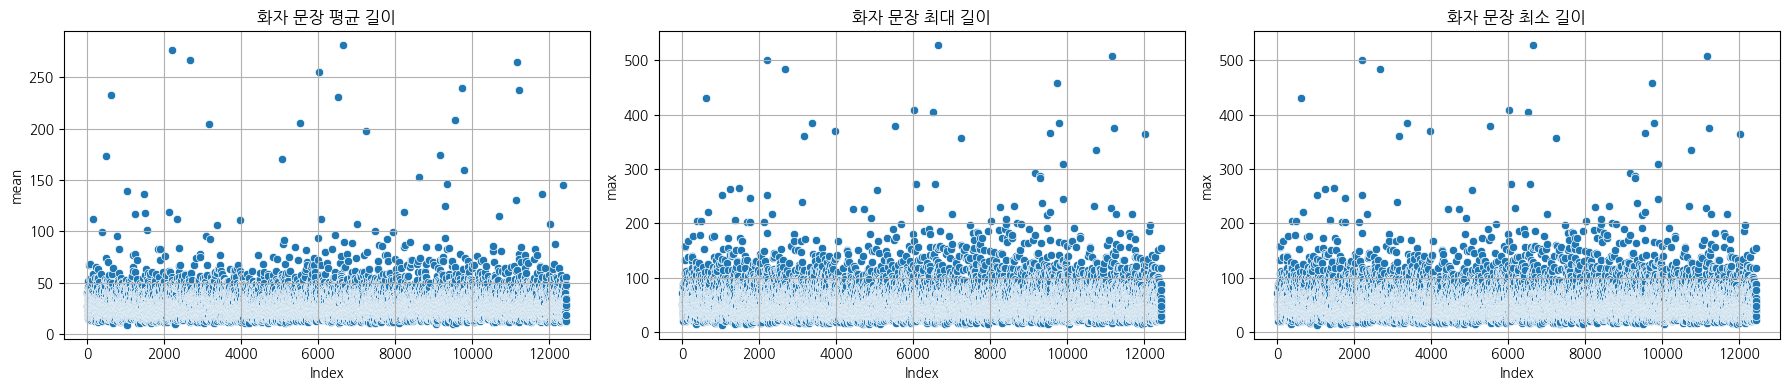

In [102]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=train_n_token_des, x=train_n_token_des.index, y='mean')
plt.title('화자 문장 평균 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=train_n_token_des, x=train_n_token_des.index, y='max')
plt.title('화자 문장 최대 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=train_n_token_des, x=train_n_token_des.index, y='max')
plt.title('화자 문장 최소 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

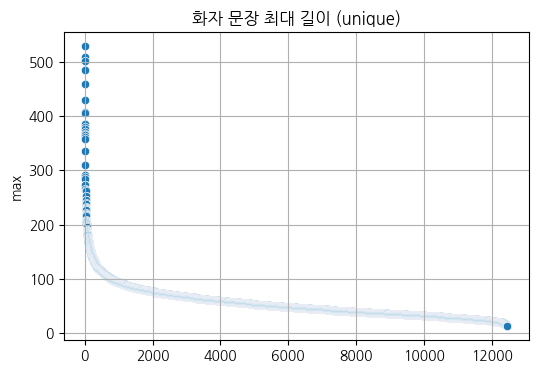

In [123]:
cond = train_n_token_des.sort_values(by='max', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=cond, x=cond.index, y='max')
plt.title('화자 문장 최대 길이 (unique)')
plt.xlabel('')
plt.grid(True)

- 화자 문장의 길이가 300 이하에 많이 분포함

In [146]:
print(len(train_n_token_des[train_n_token_des['max'] > 300]))

19


In [147]:
train_cond_idx = train_n_token_des[train_n_token_des['max'] > 300].index

for idx in train_cond_idx:
    print('-----'*20)
    print('[대화]')
    print(train_df.iloc[idx, 1])
    print('[요약]')
    print(train_df.iloc[idx, 2])

----------------------------------------------------------------------------------------------------
[대화]
#Person1#: 그럼, 대부분의 사람들이 목표를 달성하는 데 실패하는 주된 이유는 무엇이라고 생각하나요?
#Person2#: 그들이 집중력을 잃어버립니다. 모든 사람의 삶은 바쁩니다. 모든 사람의 삶에는 너무 많은 일이 일어납니다. 무슨 일이 일어나는지는 그들이 목표를 가지고 있을 수도 있고 뭔가가 그것을 방해할 수도 있다는 것입니다. 아마 그들의 목표는 매년 휴가를 가고 싶어하는 것일 수 있고, 그들은 상사에게 휴가 신청서를 제출하게 됩니다. 그런데 상사가 한 달 더 기다려달라고 요청하고, 또 한 달 더 기다리라고 할 수 있습니다. 즉, 다양한 것들이 그들의 길을 막게 되고, 사람들은 자신의 목표를 위해 대항하지 않습니다. 그들은 그것을 위해 투쟁하지 않습니다. 그들은 다른 힘에게 자신을 약간 밀리게 합니다. 또한, 많은 사람들이 목표를 설정하지 않습니다; 그들은 그렇게 생각합니다. 하지만 그것은 꿈이거나 매우 느슨한 목표일 뿐입니다. 그래서 그들이 삶에서 필요한 행동에 대한 결정을 내려야 할 때, 목표는 그들의 마음 속에서 너무 멀리 떨어져 있어서 그것의 최선의 이익을 위해 행동하지 않습니다. 또한 사람들은 앉아서 '오, 내 목표들이 여기 있다'고 말하고 그것들을 모두 잊어버립니다. 매주 그것들을 다시 보는 것이 좋은 방법입니다. 그러면 그것들이 당신의 마음 속에서 가장 먼저 떠오르게 되어 그것을 바탕으로 행동을 취할 수 있습니다.
[요약]
#Person1#은 #Person2#에게 대부분의 사람들이 목표를 달성하지 못하는 이유를 묻는다. #Person2#는 사람들이 집중력을 잃거나 목표를 설정하지 않기 때문이라고 답한다.
----------------------------------------------------------------------------------

## Valid

In [134]:
dev_n_split = []
for idx in tqdm(range(0, dev_df.shape[0])):
    text = dev_df.iloc[idx, 1]
    text2 = text.split('\n')
    dev_n_split.append(text2)

100%|██████████| 499/499 [00:00<00:00, 43761.92it/s]


In [135]:
dev_n_token = []
for idx in tqdm(range(0, dev_df.shape[0])):
    temp = []
    for text in dev_n_split[idx]:
        token = tokenizer(text)
        inp_ids = len(token['input_ids'])
        temp.append(inp_ids)
    dev_n_token.append(temp)

100%|██████████| 499/499 [00:00<00:00, 1683.36it/s]


In [136]:
# mean, max, min

dev_n_token_series = pd.Series(dev_n_token, name='dialogue')

dev_n_token_mean = dev_n_token_series.apply(lambda x: np.mean(x))
dev_n_token_max = dev_n_token_series.apply(lambda x: np.max(x))
dev_n_token_min = dev_n_token_series.apply(lambda x: np.min(x))

dev_n_token_mean.name = 'mean'
dev_n_token_max.name = 'max'
dev_n_token_min.name = 'min'

In [137]:
temp = dev_n_token_mean.reset_index()
temp1 = dev_n_token_max.reset_index(drop=True)
temp2 = dev_n_token_min.reset_index(drop=True)

dev_n_token_des = pd.concat([temp, temp1, temp2], axis=1, join='inner')

In [138]:
dev_n_token_des[['mean', 'max', 'min']].describe()

,mean,max,min
count,499.000000,499.000000,499.000000
mean,28.897432,55.997996,12.507014
std,12.826949,31.800489,6.660548
min,12.500000,17.000000,6.000000
25%,20.550000,35.000000,8.000000
50%,25.833333,49.000000,11.000000
75%,33.666667,66.500000,15.000000
max,137.750000,325.000000,53.000000


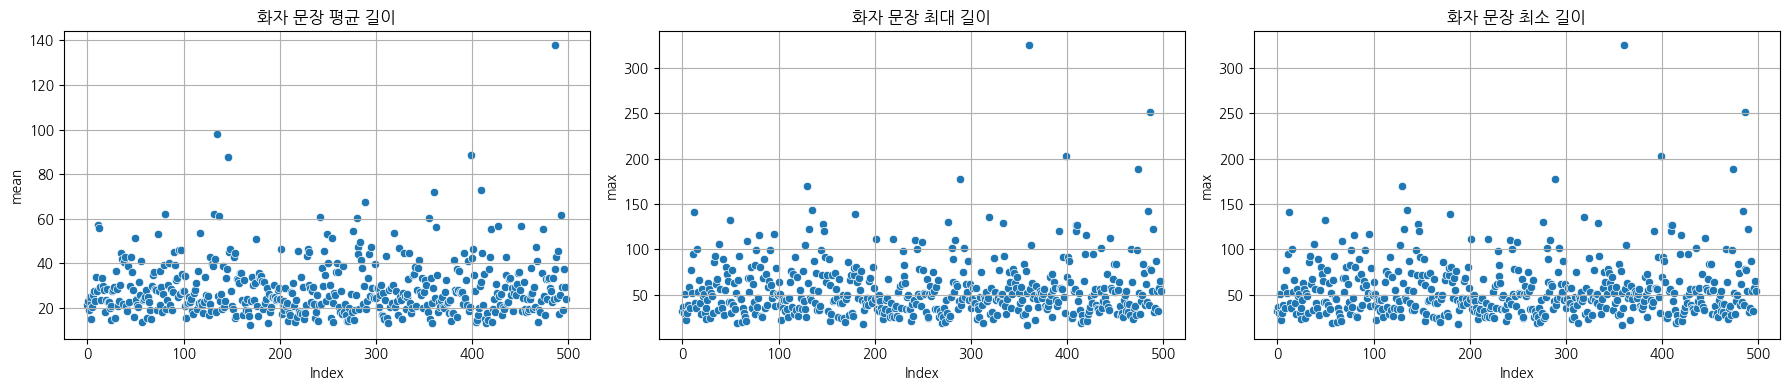

In [139]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dev_n_token_des, x=dev_n_token_des.index, y='mean')
plt.title('화자 문장 평균 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=dev_n_token_des, x=dev_n_token_des.index, y='max')
plt.title('화자 문장 최대 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=dev_n_token_des, x=dev_n_token_des.index, y='max')
plt.title('화자 문장 최소 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

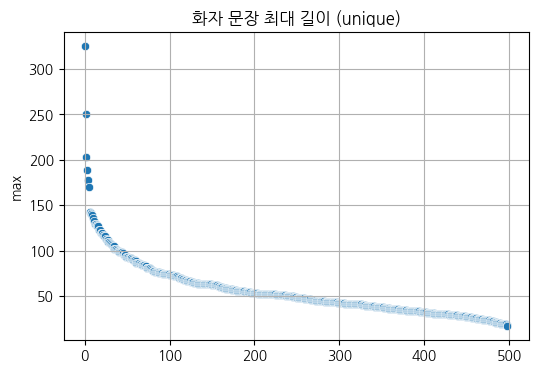

In [140]:
cond = dev_n_token_des.sort_values(by='max', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=cond, x=cond.index, y='max')
plt.title('화자 문장 최대 길이 (unique)')
plt.xlabel('')
plt.grid(True)

- 화자 문장의 길이가 150 이하에 많이 분포함

In [141]:
print(len(dev_n_token_des[dev_n_token_des['max'] > 150]))

6


In [144]:
dev_cond_idx = dev_n_token_des[dev_n_token_des['max'] > 150].index

for idx in dev_cond_idx:
    print('-----'*20)
    print('[대화]')
    print(dev_df.iloc[idx, 1])
    print('[요약]')
    print(dev_df.iloc[idx, 2])

----------------------------------------------------------------------------------------------------
[대화]
#Person1#: 안녕하세요, 어떻게 도와드릴까요?
#Person2#: 제 금목걸이가 도난당했습니다.
#Person1#: 그런 일이 있었다니 유감스럽습니다. 제 사무실로 함께 가서 정확히 어떤 일이 있었는지 말씀해주실 수 있을까요?
#Person2#: 물론입니다.
#Person1#: 혹시 방 안 어딘가에 있지는 않은지 확실하신가요?
#Person2#: 네, 제 방을 다 뒤져봤는데 찾을 수 없습니다.
#Person1#: 알겠습니다, 마지막으로 언제 어디에서 보셨나요?
#Person2#: 어제 밤에 화장대 위에서요. 샤워하기 전에 벗어놓고 샤워 후에 다시 차지 않았습니다. 그리고 오늘 아침에 급하게 호텔을 나섰는데 차지 않고 나왔어요.
#Person1#: 오늘 아침에 차지 않았다는 것이 확실한가요?
#Person2#: 네, 확실합니다.
#Person1#: 그럼 나가실 때 문을 잠그셨나요?
#Person2#: 네, 잠갔던 것 같아요. 여기 메이드 중 한 명이 가져갔을 거에요. 제 목걸이를 돌려받고 싶습니다.
#Person1#: 그렇군요, 그런 기분이 드실 것 같습니다. 최선을 다해 도와드리겠습니다. 하지만 먼저 제가 하우스메이드 한 명을 보내서 다시 한번 꼼꼼히 찾아보도록 하겠습니다. 만약 그녀가 찾아내면 모두가 기뻐할 것입니다. 그렇지 않다면 이 문제를 경찰에 넘기겠습니다. 하지만 호텔은 귀하의 손실에 대해 책임을 지지 않는다는 것을 말씀드려야 합니다. 귀하의 금목걸이는 호텔의 안전 상자에 보관해야 했습니다. 키 카드를 주의 깊게 읽었다면 이를 특별히 경고하고 있음을 알았을 것입니다.
#Person2#: 그건 충분하지 않아요. 당신의 총괄 관리자를 불러주세요. 지금 그와 이야기하고 싶습니다.
#Person1#: 죄송합니다만, 총괄 관리자님은 도시 밖에 계십니다. 하지만 부관리

## Test

In [148]:
test_n_split = []
for idx in tqdm(range(0, test_df.shape[0])):
    text = test_df.iloc[idx, 1]
    text2 = text.split('\n')
    test_n_split.append(text2)

100%|██████████| 499/499 [00:00<00:00, 44180.39it/s]


In [149]:
test_n_token = []
for idx in tqdm(range(0, test_df.shape[0])):
    temp = []
    for text in test_n_split[idx]:
        token = tokenizer(text)
        inp_ids = len(token['input_ids'])
        temp.append(inp_ids)
    test_n_token.append(temp)

100%|██████████| 499/499 [00:00<00:00, 1646.84it/s]


In [150]:
# mean, max, min

test_n_token_series = pd.Series(test_n_token, name='dialogue')

test_n_token_mean = test_n_token_series.apply(lambda x: np.mean(x))
test_n_token_max = test_n_token_series.apply(lambda x: np.max(x))
test_n_token_min = test_n_token_series.apply(lambda x: np.min(x))

test_n_token_mean.name = 'mean'
test_n_token_max.name = 'max'
test_n_token_min.name = 'min'

In [151]:
temp = test_n_token_mean.reset_index()
temp1 = test_n_token_max.reset_index(drop=True)
temp2 = test_n_token_min.reset_index(drop=True)

test_n_token_des = pd.concat([temp, temp1, temp2], axis=1, join='inner')

In [152]:
test_n_token_des[['mean', 'max', 'min']].describe()

,mean,max,min
count,499.000000,499.000000,499.000000
mean,28.614874,54.805611,12.132265
std,11.737113,29.463685,6.129013
min,11.250000,14.000000,5.000000
25%,20.535714,35.000000,8.000000
50%,26.230769,47.000000,11.000000
75%,33.041667,66.000000,14.000000
max,121.666667,232.000000,46.000000


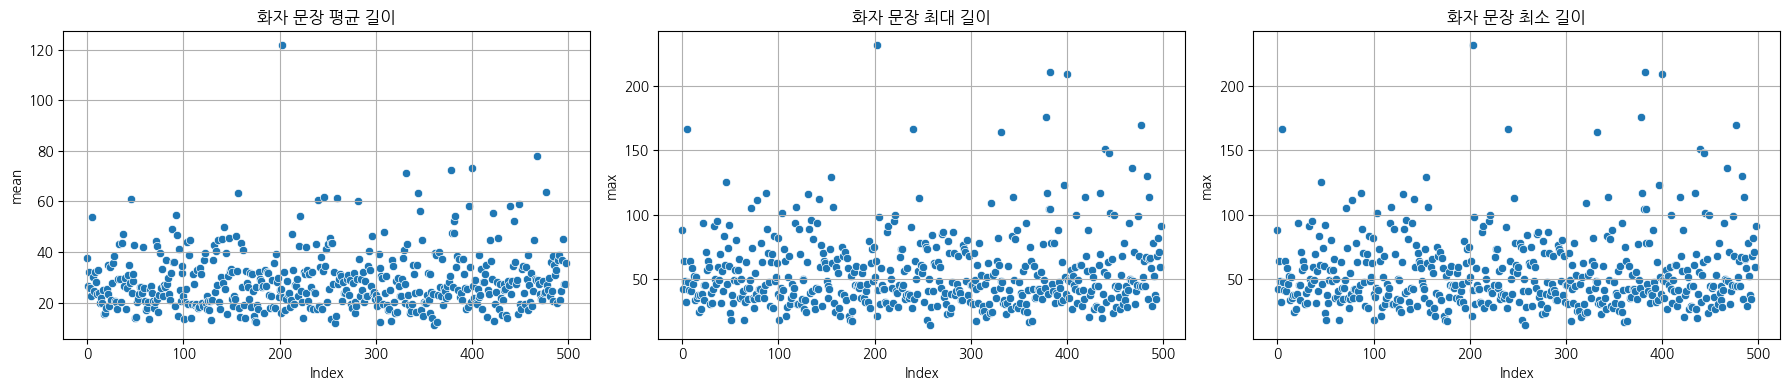

In [153]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=test_n_token_des, x=test_n_token_des.index, y='mean')
plt.title('화자 문장 평균 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=test_n_token_des, x=test_n_token_des.index, y='max')
plt.title('화자 문장 최대 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=test_n_token_des, x=test_n_token_des.index, y='max')
plt.title('화자 문장 최소 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

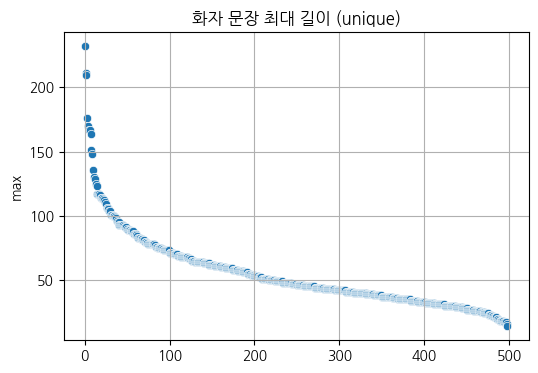

In [154]:
cond = test_n_token_des.sort_values(by='max', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=cond, x=cond.index, y='max')
plt.title('화자 문장 최대 길이 (unique)')
plt.xlabel('')
plt.grid(True)

- 화자 문장의 길이가 140 이하에 많이 분포함

In [171]:
print(len(test_n_token_des[test_n_token_des['max'] > 140]))

10


In [173]:
test_cond_idx = test_n_token_des[test_n_token_des['max'] > 140].index

for idx in test_cond_idx:
    print('-----'*20)
    print('[대화]')
    print(test_df.iloc[idx, 1])

----------------------------------------------------------------------------------------------------
[대화]
#Person1#: 진짜 짜증나! 이런 회사에서 일하는 건 나에게 아무런 도움이 안 돼!
#Person2#: 그럼 어떻게 할 거야? 그냥 그만두려고?
#Person1#: 그게 바로 내가 할 거야! 내 회사를 창업하기로 결정했어! 사업 계획서를 작성하고, 투자자를 모집하고, 나 자신을 위해 일하기로 했어!
#Person2#: 너 사업 계획서를 작성해 본 적 있어?
#Person1#: 음, 아니, 그렇게 어렵지 않을 거야! 그러니까, 당신이 어떤 사업을 하고, 어떻게 일을 할 것인지 설명하면 되는 거잖아, 그게 전부지? 
#Person2#: 너는 더 이상 틀릴 수 없어! 잘 작성된 사업 계획서에는 사업 아이디어를 두 페이지 이내로 강조하는 요약문이 포함되어야 해. 그리고 회사에 대해 설명해야 해. 법적 구조, 역사 등의 정보를 포함해서 말이야.
#Person1#: 음, 그 정도면 충분히 할 수 있을 것 같아.
#Person2#: 기다려, 더 있어! 그 다음에는 상품이나 서비스를 소개하고 설명해야 해. 그것들이 무엇이고 경쟁자와 어떻게 다른지 말이야. 그리고 어려운 부분인 시장 분석이야. 수백 가지 변수를 조사하고 분석해야 해! 1인당 GDP부터 인구가 평균적으로 얼마나 많은 아이를 가지고 있는지와 같은 사회경제적 요인을 고려해야 해! 이 모든 정보는 당신이 전략과 실행 단계로 넘어가서 실제로 어떻게 아이디어를 실행할 것인지 자세히 설명할 수 있도록 도와줄 거야.
#Person1#: 이런. 그게 다야?
#Person2#: 거의 다야, 투자자들에게 가장 중요한 정보는 재무 분석이야. 여기서 매출, 현금 흐름, 이익을 계산하고 예측해야 해. 결국, 사람들은 투자에 대한 수익을 언제 볼 수 있을지 알고 싶어할 거야!
#Person1#: 음. 나는 그냥 내 예전 일을 계속하고 사업을 시

## train_cond_idx, dev_cond_idx 처리

In [174]:
train_df_copy = train_df.copy()
dev_df_copy = dev_df.copy()

In [176]:
train_df_drop = train_df_copy.drop(index=train_cond_idx)
dev_df_drop = dev_df_copy.drop(index=dev_cond_idx)

In [177]:
print(train_df_copy.shape[0], train_df_drop.shape[0])
print(dev_df_copy.shape[0], dev_df_drop.shape[0])

12457 12438
499 493


In [178]:
train_df_drop.to_csv('../../data/train_token-check.csv', index=False)
dev_df_drop.to_csv('../../data/dev_token-check.csv', index=False)